In [1]:
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def data_load():
    files = glob.glob('../data/*')
    if not files:
        print("Chck Phath")
        sys.exit()
    else:
        files.remove(r'../data\raw_data')
        files.remove(r'../data\raw_data_')

    _feature=[]
    label=[]
    for address in files:
        label_ = os.path.basename(address)
        for num in glob.glob(address+'/*'):
            _feature.append(np.load(num))
            label.append([label_])
        print(label_)
    target = np.array(label).flatten()
    return _feature, target.reshape((-1,))

features, label = data_load()
encoder = LabelEncoder()
target = encoder.fit_transform(label)


X_train,  X_valid, y_train, y_valid = train_test_split(np.array(features), target, test_size=0.2, random_state=0)
X_test,  X_valid, y_test, y_valid = train_test_split(np.array(features), target, test_size=0.5, random_state=0)
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

y_test_raw = y_test.copy()
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
number_of_classes = y_valid.shape[1]

around
b
fracture
ground
mechanics
science
smile
strain
stress
t


In [10]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
     def get_config(self):
        config = super().get_config().copy()
        config.update({
            'activation' : self.activation,
            'main_layers' : self.main_layers,
            'skip_layers' : self.skip_layers,
        })
        return config

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

IndentationError: unindent does not match any outer indentation level (<ipython-input-10-2f49ade99fce>, line 21)

In [ ]:
model = keras.models.Sequential()

model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[210, 210, 10]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy", keras.metrics.TopKCategoricalAccuracy()])
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

training_acc = history.history["accuracy"]
test_acc = history.history["val_accuracy"]

plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["training_loss", "test_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('./figure/loss.png',dpi=300,bbox_inches='tight')

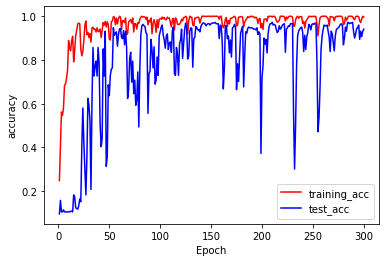

In [3]:
plt.plot(epoch_count, training_acc, "r-")
plt.plot(epoch_count, test_acc, "b-")
plt.legend(["training_acc", "test_acc"])
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.savefig('./figure/acc.png',dpi=300,bbox_inches='tight')

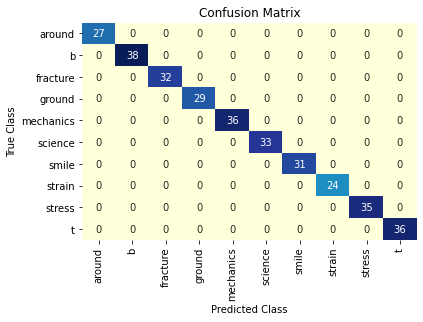

In [4]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_prediction = model.predict(X_test)

matrix = confusion_matrix(encoder.inverse_transform(y_test_raw), encoder.inverse_transform(np.argmax(y_prediction, axis=1)))


dataframe = pd.DataFrame(matrix, index = np.unique(label), columns=np.unique(label))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.savefig('./figure/heaat.png',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
model.save("ResNet.h5")

NotImplementedError: Layers with arguments in `__init__` must override `get_config`.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 105, 105, 64)      31360     
_________________________________________________________________
batch_normalization (BatchNo (None, 105, 105, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 105, 105, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 53, 53, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 53, 53, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 53, 53, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 53, 53, 64)        7

In [8]:
print(score)

[0.3576197699175104, 0.9409938, 0.98136646]
